In [1]:
import os,sys
import uproot
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout
import warnings
warnings.filterwarnings('ignore')
import joblib
#import shap
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])

In [2]:
pjoin = os.path.join

In [3]:
Mass = 150

In [4]:
inputdir='/home/arnab/Arnab/Work/PhD2022/VLLAnalysisUL/external/InputFiles'

folder_2016postVFP = 'VLL2016postVFP_1L2JAnalysisTree_May18_v0'
folder_2016preVFP='VLL2016preVFP_1L2JAnalysisTree_May3_v0'
folder_2017='VLL2017_1L2JAnalysisTree_Jun25_v0'
folder_2018='VLL2018_1L2JAnalysisTree_Jun25_v0'

#Specially create MVA Trees for very large ttbar sample
#Each era has sufficiently numbers of samples events(250K)
bkgfile1 = f'/home/arnab/Arnab/Work/MyBasic/AnalysisModules/AnalysisModules/MVA/MVATrees/VLL2016postVFP_MVATree_TTBar_TTToSemiLeptonic_sample.root'
bkgfile2 = f'/home/arnab/Arnab/Work/MyBasic/AnalysisModules/AnalysisModules/MVA/MVATrees/VLL2016preVFP_MVATree_TTBar_TTToSemiLeptonic_sample.root'
bkgfile3 = f'/home/arnab/Arnab/Work/MyBasic/AnalysisModules/AnalysisModules/MVA/MVATrees/VLL2017_MVATree_TTBar_TTToSemiLeptonic_sample.root'

vllfile   = f'VLL_M{Mass}_sample.root'


bkgfilelist = [f'{bkgfile1}',f'{bkgfile2}',f'{bkgfile3}']

vllfilelist   = [f'{folder_2016postVFP}_{vllfile}',f'{folder_2016preVFP}_{vllfile}',f'{folder_2017}_{vllfile}']                

In [5]:
bkgfile_2016postVFP = bkgfilelist[0]
bkgfile_2016preVFP = bkgfilelist[1]
bkgfile_2017 = bkgfilelist[2]

vllfile_2016postVFP = pjoin(pjoin(inputdir,folder_2016postVFP),vllfilelist[0])
vllfile_2016preVFP = pjoin(pjoin(inputdir,folder_2016preVFP),vllfilelist[1])
vllfile_2017 = pjoin(pjoin(inputdir,folder_2017),vllfilelist[2])

In [6]:
def load_data(fname):
    events= uproot.open(fname+":events_1L2J")
    #print(f"Tree Variables \n{events.keys()}")
    df = events.arrays(library='pd')
    return df

In [7]:
bkgdf_2016postVFP = load_data(bkgfile_2016postVFP)
bkgdf_2016preVFP = load_data(bkgfile_2016preVFP)
bkgdf_2017 = load_data(bkgfile_2017)

sigdf_2016postVFP = load_data(vllfile_2016postVFP)
sigdf_2016preVFP = load_data(vllfile_2016preVFP)
sigdf_2017 = load_data(vllfile_2017)


In [8]:
bkgdf = pd.concat([bkgdf_2016postVFP,bkgdf_2016preVFP,bkgdf_2017])
sigdf = pd.concat([sigdf_2016postVFP,sigdf_2016preVFP,sigdf_2017])

In [9]:
print(f'Total bkg events available for training(2016preVFP+2016postVFP+2017)={bkgdf.shape[0]}')
print(f'Total sig events available for training(2016preVFP+2016postVFP+2017)={sigdf.shape[0]}')

print(f'Total Features = {sigdf.shape[1]}')

Total bkg events available for training(2016preVFP+2016postVFP+2017)=750000
Total sig events available for training(2016preVFP+2016postVFP+2017)=77890
Total Features = 44


In [10]:
## Print available features
sigdf.columns

Index(['nEvt', 'lep0_flavor', 'lep0_pt', 'lep0_phi', 'lep0_eta', 'lep0_iso',
       'lep0_mt', 'lep0_sip3d', 'lep0_deepjet', 'jet0_pt', 'jet0_phi',
       'jet0_eta', 'jet0_mt', 'jet1_pt', 'jet1_phi', 'jet1_eta', 'jet1_mt',
       'dijet_mass', 'dijet_pt', 'dijet_mt', 'deltaR_jet01',
       'deltaPhi_metjet0', 'deltaPhi_metjet1', 'deltaPhi_metlep0',
       'deltaPhi_jet0lep0', 'deltaPhi_jet1lep0', 'deltaPhi_dijetlep0',
       'deltaPhi_metdijet', 'event_MET', 'event_HT', 'event_ST', 'n_Jet',
       'n_bJet', 'event_btagsf', 'ljjsys_PT', 'deltaPhi_ljjsysmet',
       'deltaPhi_ljjsyslep0', 'deltaPhi_ljjsysjet0', 'deltaPhi_ljjsysjet1',
       'ljjsys_mass', 'deepjetQG_jet0', 'deepjetQG_jet1', 'event_avgQGscore',
       'event_Rpt'],
      dtype='object')

# Preselection events for the training

In [11]:
selection = 'lep0_iso<0.15 & deltaR_jet01<2.0 & event_ST>250'
#selection = 'lep0_iso<0.15'
sigdf = sigdf.query(selection)
bkgdf = bkgdf.query(selection)

In [12]:
print(f'Total bkg events available for training(after SR preselection)={bkgdf.shape[0]}')
print(f'Total sig events available for training(after SR preselection)={sigdf.shape[0]}')

print(f'Total Features = {sigdf.shape[1]}')

Total bkg events available for training(after SR preselection)=391391
Total sig events available for training(after SR preselection)=36149
Total Features = 44


### NNVarlist

In [13]:
nnvar = ['lep0_pt', 'lep0_phi', 'lep0_eta','lep0_mt','jet0_pt',
       'jet0_eta', 'jet0_mt', 'jet1_pt','jet1_eta', 'jet1_mt',
       'dijet_mass', 'dijet_pt', 'dijet_mt', 'deltaR_jet01',
       'deltaPhi_metjet0', 'deltaPhi_metjet1', 'deltaPhi_metlep0',
       'deltaPhi_jet0lep0', 'deltaPhi_jet1lep0', 'deltaPhi_dijetlep0',
       'deltaPhi_metdijet', 'event_MET', 'event_HT', 'event_ST', 'n_Jet',
       'ljjsys_PT', 'deltaPhi_ljjsysmet','deltaPhi_ljjsyslep0',
       'deltaPhi_ljjsysjet0', 'deltaPhi_ljjsysjet1','ljjsys_mass',
       'deepjetQG_jet0', 'deepjetQG_jet1', 'event_avgQGscore','event_Rpt']

In [14]:
def plotInput(sigdf_,bkgdf_,varlist):
    for inputvar in varlist:
        nbkg=f"[{bkgdf_.shape[0]}]"
        nsig=f"[{sigdf_.shape[0]}]"
        plt.figure(figsize=(8,6))
        plt.hist(sigdf_[inputvar],bins=20,ls='-',lw=3,label='Signal'+nsig,histtype='step',log=True,density=True)    
        plt.hist(bkgdf_[inputvar],bins=20,ls='--',lw=2,label='Background'+nbkg,log=True,density=True,alpha=0.5)    
        plt.legend(fontsize=12)
        plt.xlabel(inputvar,fontsize=20)
        plt.ylabel('counts',fontsize=20)
        plt.show()

In [15]:
#plotInput(sigdf,bkgdf,nnvar)

### Assign Label

In [16]:
sigdf = sigdf[nnvar]
sigdf['label']=1
bkgdf = bkgdf[nnvar]
bkgdf['label']=0
bkgdf=bkgdf.sample(sigdf.shape[0]+20000)

In [17]:
data = pd.concat([sigdf,bkgdf])

In [18]:
X, y = data.values[:, :-1], data.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, test_size=0.5)
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test  = np.asarray(X_test).astype(np.float32)
y_test  = np.asarray(y_test).astype(np.float32)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train)
n_features = X_train.shape[1]
print(f'No of Features ={n_features}')


(46149, 35) (46149, 35) (46149,) (46149,)
[0. 0. 0. ... 0. 0. 1.]
No of Features =35


In [19]:
#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler=StandardScaler()
scaler=MinMaxScaler((0,1))
scaler.fit(X_train)
#transform    
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


In [20]:
modelname = 'trainzjets'
modelfiledir='output/'

epoch = 40
batchsize = 1000

In [21]:
#define callbacks. Here the model with highest accuracy will be saved at end...
cb = [ModelCheckpoint(filepath=f"{modelfiledir}best_model_{modelname}.h5",monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
"""
Model Architecture
"""
model = Sequential()
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))


In [22]:
#compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
#do the training
history = model.fit(X_train_scaled,y_train, epochs=epoch, batch_size=batchsize,validation_data=(X_test_scaled, y_test), verbose=1,callbacks=cb)
#print the information, and save the final model
model.summary()
model.save(f'{modelfiledir}{modelname}.h5')
joblib.dump(scaler,f'{modelfiledir}scaler_{modelname}.save')


Epoch 1/64
42/47 [=========================>....] - ETA: 0s - loss: 0.6597 - accuracy: 0.6098
Epoch 00001: val_accuracy improved from -inf to 0.64684, saving model to output/best_model_trainzjets.h5
47/47 [==============================] - 1s 14ms/step - loss: 0.6581 - accuracy: 0.6116 - val_loss: 0.6284 - val_accuracy: 0.6468
Epoch 2/64
43/47 [==========================>...] - ETA: 0s - loss: 0.6292 - accuracy: 0.6523
Epoch 00002: val_accuracy improved from 0.64684 to 0.68309, saving model to output/best_model_trainzjets.h5
47/47 [==============================] - 0s 10ms/step - loss: 0.6280 - accuracy: 0.6532 - val_loss: 0.5987 - val_accuracy: 0.6831
Epoch 3/64
45/47 [===========================>..] - ETA: 0s - loss: 0.6036 - accuracy: 0.6784
Epoch 00003: val_accuracy improved from 0.68309 to 0.69698, saving model to output/best_model_trainzjets.h5
47/47 [==============================] - 0s 9ms/step - loss: 0.6038 - accuracy: 0.6787 - val_loss: 0.5788 - val_accuracy: 0.6970
Epoch 4/

47/47 [==============================] - 0s 10ms/step - loss: 0.5368 - accuracy: 0.7322 - val_loss: 0.5312 - val_accuracy: 0.7336
Epoch 27/64
43/47 [==========================>...] - ETA: 0s - loss: 0.5353 - accuracy: 0.7331
Epoch 00027: val_accuracy did not improve from 0.73358
47/47 [==============================] - 0s 9ms/step - loss: 0.5363 - accuracy: 0.7318 - val_loss: 0.5320 - val_accuracy: 0.7324
Epoch 28/64
45/47 [===========================>..] - ETA: 0s - loss: 0.5353 - accuracy: 0.7321
Epoch 00028: val_accuracy did not improve from 0.73358
47/47 [==============================] - 0s 9ms/step - loss: 0.5350 - accuracy: 0.7317 - val_loss: 0.5307 - val_accuracy: 0.7324
Epoch 29/64
44/47 [===========================>..] - ETA: 0s - loss: 0.5335 - accuracy: 0.7344
Epoch 00029: val_accuracy did not improve from 0.73358
47/47 [==============================] - 0s 9ms/step - loss: 0.5341 - accuracy: 0.7343 - val_loss: 0.5304 - val_accuracy: 0.7325
Epoch 30/64
43/47 [==============

Epoch 55/64
44/47 [===========================>..] - ETA: 0s - loss: 0.5214 - accuracy: 0.7406
Epoch 00055: val_accuracy did not improve from 0.73620
47/47 [==============================] - 0s 9ms/step - loss: 0.5213 - accuracy: 0.7407 - val_loss: 0.5262 - val_accuracy: 0.7358
Epoch 56/64
44/47 [===========================>..] - ETA: 0s - loss: 0.5211 - accuracy: 0.7425
Epoch 00056: val_accuracy did not improve from 0.73620
47/47 [==============================] - 0s 9ms/step - loss: 0.5212 - accuracy: 0.7425 - val_loss: 0.5265 - val_accuracy: 0.7352
Epoch 57/64
42/47 [=========================>....] - ETA: 0s - loss: 0.5216 - accuracy: 0.7405
Epoch 00057: val_accuracy did not improve from 0.73620
47/47 [==============================] - 0s 9ms/step - loss: 0.5213 - accuracy: 0.7408 - val_loss: 0.5255 - val_accuracy: 0.7356
Epoch 58/64
46/47 [============================>.] - ETA: 0s - loss: 0.5209 - accuracy: 0.7413
Epoch 00058: val_accuracy improved from 0.73620 to 0.73716, saving m

['output/scaler_trainzjets.save']

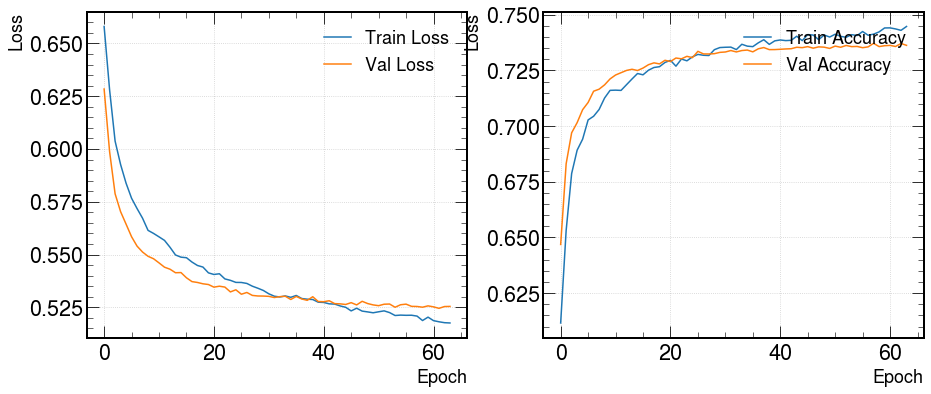

In [24]:
"""
Accuracy and Loss plots
"""

fig,ax = plt.subplots(1,2,figsize=(15,6))
ax =ax.flatten()

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label = 'Val Loss')
ax[0].set_xlabel('Epoch',fontsize=18)
ax[0].set_ylabel('Loss',fontsize=18)
#ax[0].set_ylim([0.001, 10])
#ax[0].set_yscale('log')
ax[0].grid('--',c='gray',alpha=0.4)
ax[0].legend(loc='upper right',fontsize=18,frameon=False)

#Accuracy
ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label = 'Val Accuracy')
ax[1].set_xlabel('Epoch',fontsize=18)
ax[1].set_ylabel('Loss',fontsize=18)
#ax[1].set_ylim([0.70,0.75])
#ax[0].set_yscale('log')
ax[1].grid('--',c='gray',alpha=0.4)
ax[1].legend(loc='upper right',fontsize=18,frameon=False)
#fig.savefig(f'{plotdir}/{modelname}_training.png',facecolor='white',dpi=200)
#fig.savefig(pp,format='pdf')


In [25]:
def plot_prob():
    """
    score plots
    """
    #Now the model is trained. The rest is plotting and evaluating.
    loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print('Test Accuracy: %.3f' % acc)

    #Setup dataframes for the probability
    t_df = pd.DataFrame()
    v_df = pd.DataFrame()
    t_df['truth'] = y_train
    t_df['prob'] = 0
    v_df['truth'] = y_test
    v_df['prob'] = 0
    
    print(y_train)
    v_prob = model.predict(X_test_scaled);
    t_prob = model.predict(X_train_scaled);
    v_df['prob'] = v_prob
    t_df['prob'] = t_prob

    plt.figure(figsize=(8,6))
    plt.hist(t_df[t_df['truth']==0]['prob'],bins=np.arange(0,1.02,0.02), histtype='step', label="Background Train", linewidth=3, color='xkcd:peach',log=True,density=True)
    plt.hist(t_df[t_df['truth']>0]['prob'],bins=np.arange(0,1.02,0.02), histtype='step', label="Signal Train", linewidth=3, color='skyblue',log=True,density=True)
    plt.hist(v_df[v_df['truth']==0]['prob'],bins=np.arange(0,1.02,0.02), histtype='step', label="Background Test", linewidth=3, color='xkcd:burnt orange',log=True,density=True)
    plt.hist(v_df[v_df['truth']>0]['prob'],bins=np.arange(0,1.02,0.02), histtype='step', label="Signal Test", linewidth=3, color='blue',log=True,density=True)
    
    plt.legend(loc='lower center')
    plt.xlabel('Score',fontsize=20)
    plt.ylabel('Events',fontsize=20)
    plt.title(f'NN Output',fontsize=20)
    plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=12)
    plt.yticks(fontsize=12)
    #plt.savefig(f'{plotdir}/{modelname}_score.png',facecolor='white',dpi=200)
    #plt.savefig(pp,format='pdf')
    
    fpr, tpr, _ = roc_curve(y_test,v_prob)
    auc_score = auc(fpr,tpr)
    fpr1, tpr1, _ = roc_curve(y_train,t_prob)
    auc_score1 = auc(fpr1,tpr1)


    #ROC CURVE
    plt.figure(figsize=(8,8))
    plt.plot(fpr,tpr,color='xkcd:denim blue', label='Test ROC (AUC = %0.4f)' % auc_score)
    plt.plot(fpr1,tpr1,color='xkcd:sky blue', label='Train ROC (AUC = %0.4f)' % auc_score1)
    plt.legend(loc='lower right',fontsize=18)
    plt.title(f'ROC Curve',fontsize=20)
    plt.xlabel('Background Efficiency',fontsize=20)
    plt.ylabel('Signal Efficiency',fontsize=20)
    plt.xlim(0.,1.)
    plt.ylim(0.,1.)
    #plt.savefig(f'{plotdir}/{modelname}_ROC.png',facecolor='white',dpi=200)
    #plt.savefig(pp,format='pdf')

Test Accuracy: 0.736
[0. 0. 0. ... 0. 0. 1.]


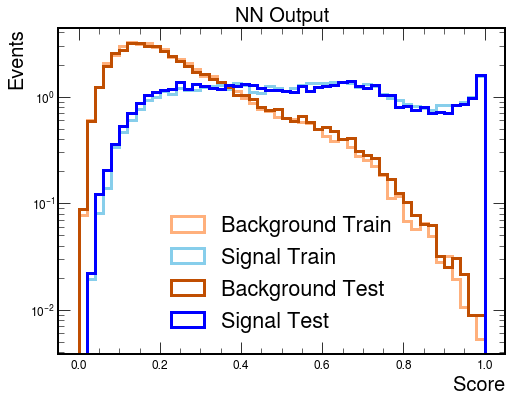

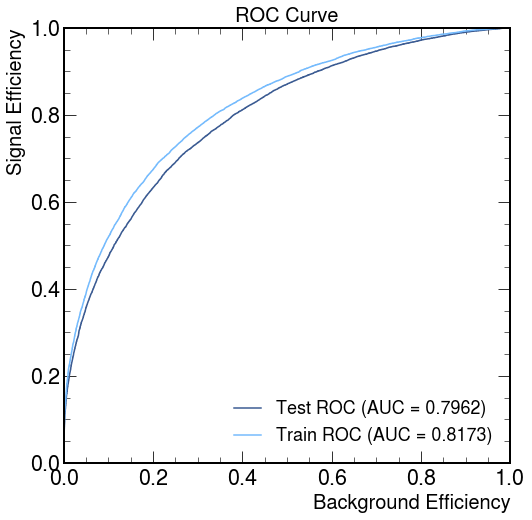

In [26]:
plot_prob()

## Feature Importance

In [27]:
def feature_permutationImportance(model_,xtest_,ytest_,features_):
    from sklearn.inspection import permutation_importance
    r = permutation_importance(model_,xtest_,ytest_,n_repeats=20,scoring="neg_mean_squared_error")
    
    #print(r.importances_mean)
    #print(r.importances_mean.argsort()[::-1])
    plt.figure(figsize=(10,14))
    for i in reversed(r.importances_mean.argsort()[::-1]):
        feat_name  = features_[i]
        mean_score = r.importances_mean[i]
        print(f"-{features_[i]}="
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")
        plt.barh(feat_name,mean_score)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
    plt.xlabel('mean_score',fontsize=20)
    #plt.ylabel('mean score',fontsize=20)
    plt.title('Features Importance',fontsize=25)
    plt.grid()
    plt.savefig('featureImp.png',dpi=150,facecolor='white')
    plt.show()



-lep0_phi=-0.000  +/- 0.000
-dijet_pt=0.000  +/- 0.000
-dijet_mass=0.000  +/- 0.000
-jet0_pt=0.000  +/- 0.000
-deltaPhi_metjet1=0.000  +/- 0.000
-ljjsys_PT=0.001  +/- 0.000
-deltaPhi_ljjsysjet1=0.001  +/- 0.000
-dijet_mt=0.001  +/- 0.000
-event_HT=0.001  +/- 0.000
-deltaPhi_jet1lep0=0.001  +/- 0.000
-event_ST=0.001  +/- 0.000
-jet1_pt=0.001  +/- 0.000
-deltaPhi_jet0lep0=0.001  +/- 0.000
-deltaPhi_metjet0=0.001  +/- 0.000
-deltaPhi_ljjsysjet0=0.001  +/- 0.000
-jet0_mt=0.001  +/- 0.000
-jet1_mt=0.001  +/- 0.000
-deepjetQG_jet1=0.002  +/- 0.000
-jet1_eta=0.002  +/- 0.000
-deltaPhi_dijetlep0=0.002  +/- 0.000
-deltaR_jet01=0.002  +/- 0.000
-jet0_eta=0.003  +/- 0.000
-deepjetQG_jet0=0.003  +/- 0.000
-lep0_pt=0.003  +/- 0.000
-deltaPhi_metdijet=0.003  +/- 0.000
-deltaPhi_ljjsysmet=0.005  +/- 0.000
-ljjsys_mass=0.006  +/- 0.000
-deltaPhi_ljjsyslep0=0.006  +/- 0.000
-deltaPhi_metlep0=0.006  +/- 0.000
-lep0_eta=0.007  +/- 0.000
-event_Rpt=0.012  +/- 0.000
-event_MET=0.012  +/- 0.000
-n_Jet=0.016

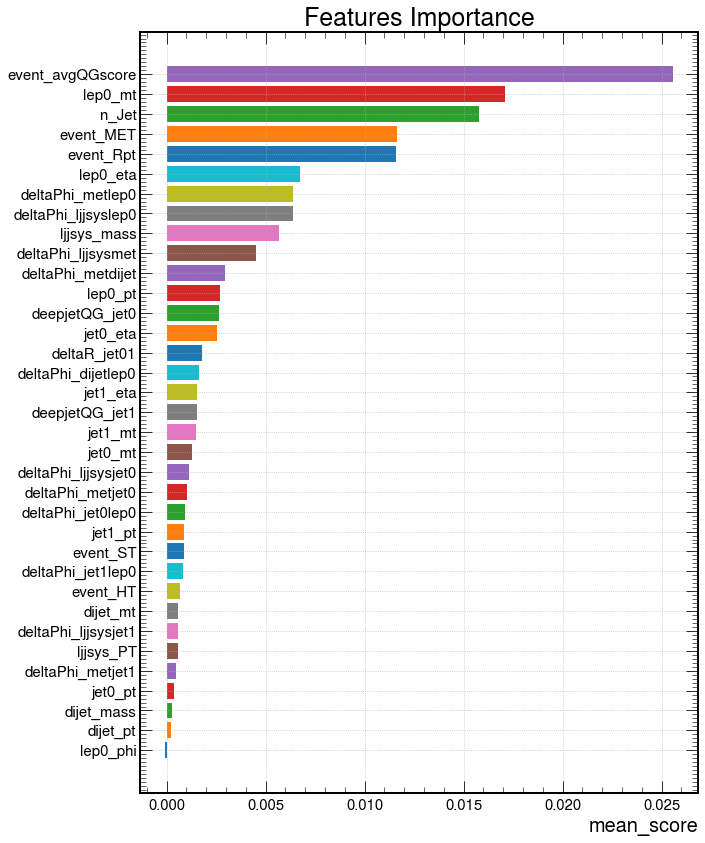

In [28]:
#feature_permutationImportance(model,X_test_scaled,y_test,nnvar)

In [35]:
def plot(var,nbins,xlo,xhi):
    plt.figure(figsize=(8,6))
    plt.hist(data[data['label']==1][var],bins=np.arange(xlo,xhi,(xhi-xlo)/nbins),histtype='step',lw=2,label='signal',density=True)
    plt.hist(data[data['label']==0][var],bins=np.arange(xlo,xhi,(xhi-xlo)/nbins),histtype='step',lw=2,label='bkg',density=True)
    plt.legend(loc='upper center')
    plt.show()

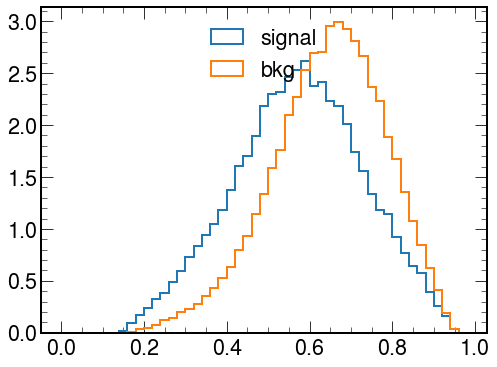

In [37]:
plot('event_avgQGscore',50,0,1)

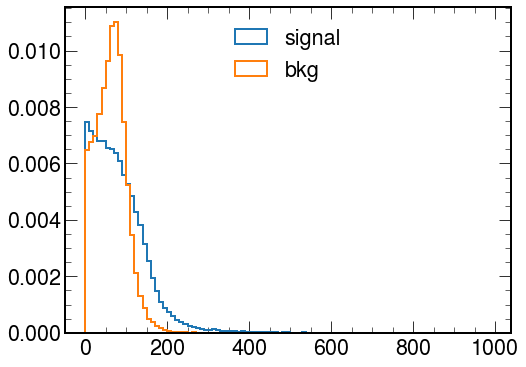

In [39]:
plot('lep0_mt',100,0,1000)

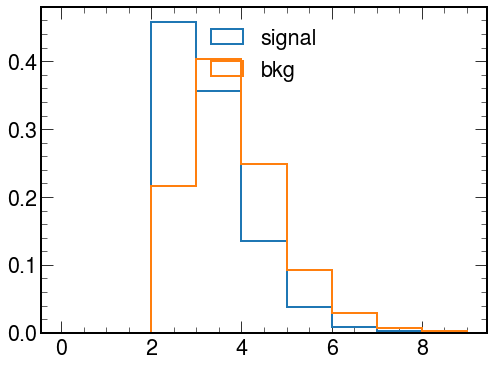

In [42]:
plot('n_Jet',10,0,10)

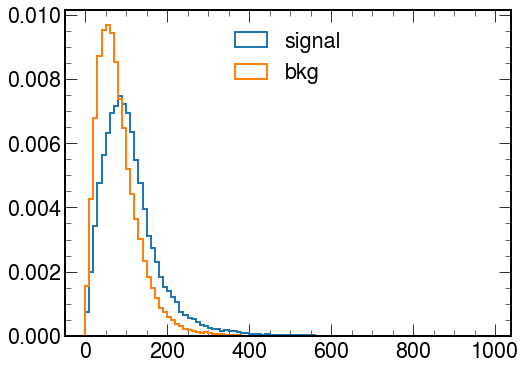

In [43]:
plot('event_MET',100,0,1000)

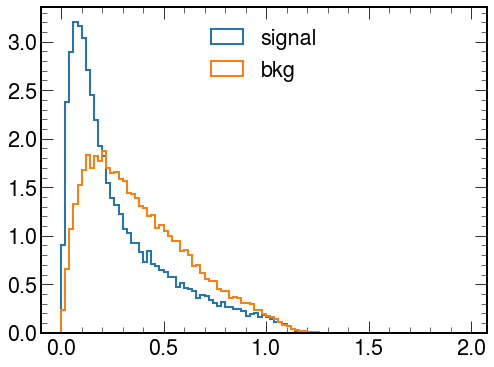

In [45]:
plot('event_Rpt',100,0,2)

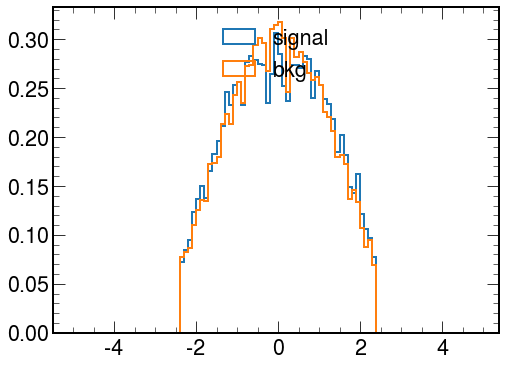

In [46]:
plot('lep0_eta',100,-5,5)

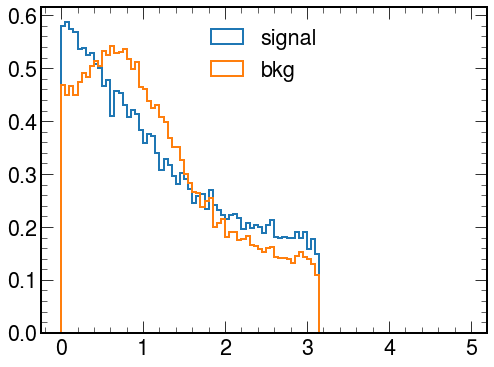

In [48]:
plot('deltaPhi_metlep0',100,0,5)

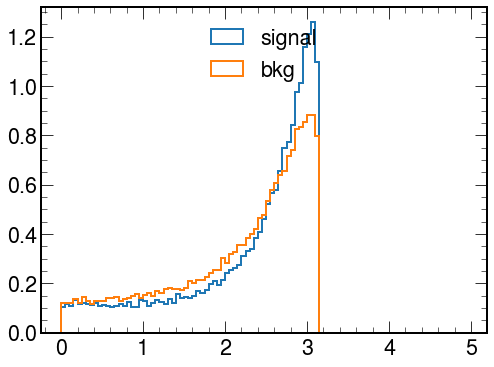

In [49]:
plot('deltaPhi_metdijet',100,0,5)

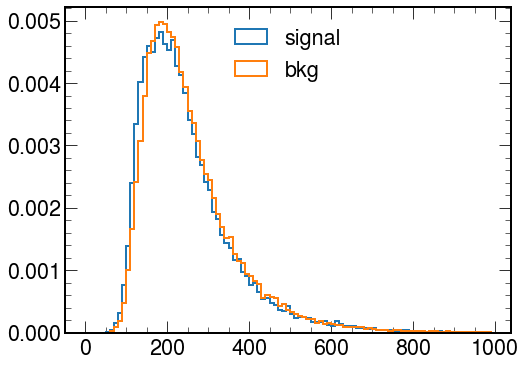

In [51]:
plot('ljjsys_mass',100,0,1000)

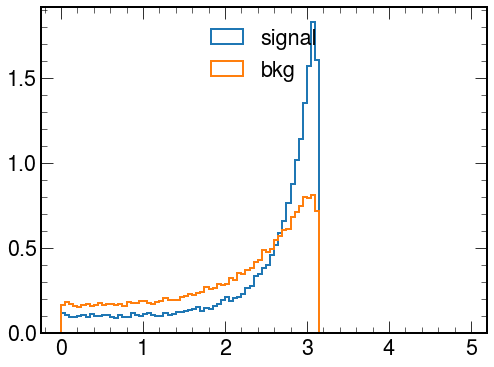

In [52]:
plot('deltaPhi_ljjsysmet',100,0,5)

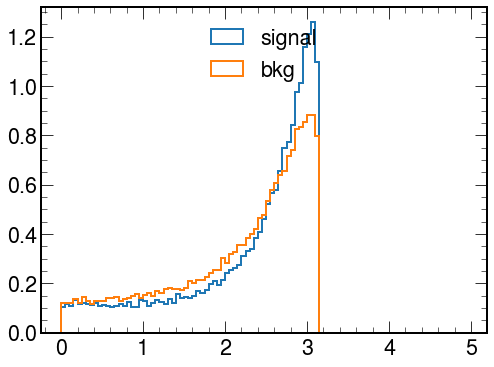

In [53]:
plot('deltaPhi_metdijet',100,0,5)

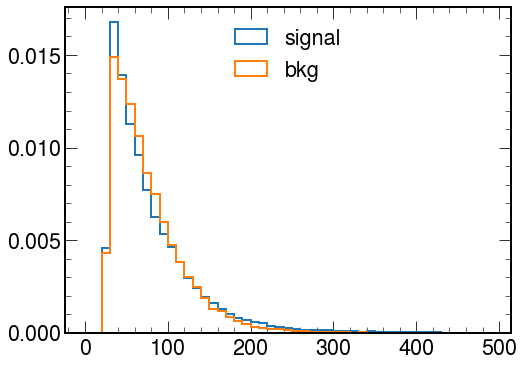

In [57]:
plot('lep0_pt',50,0,500)

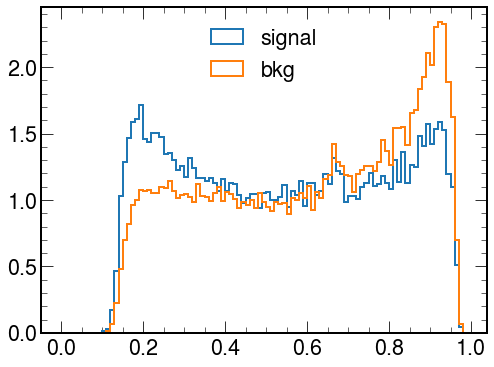

In [58]:
plot('deepjetQG_jet0',100,0,1)

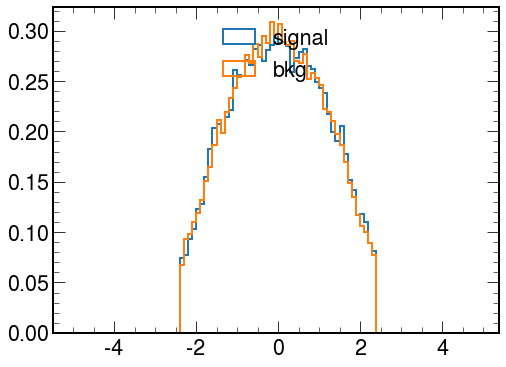

In [59]:
plot('jet0_eta',100,-5,5)

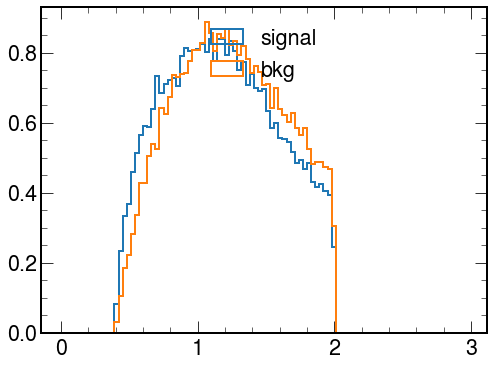

In [61]:
plot('deltaR_jet01',100,0,3)

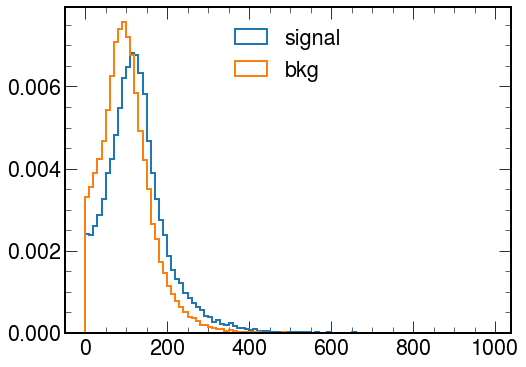

In [65]:
plot('jet1_mt',100,0,1000)

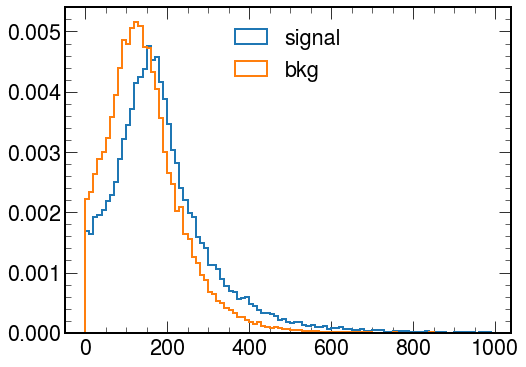

In [109]:
plot('jet0_mt',100,0,1000)

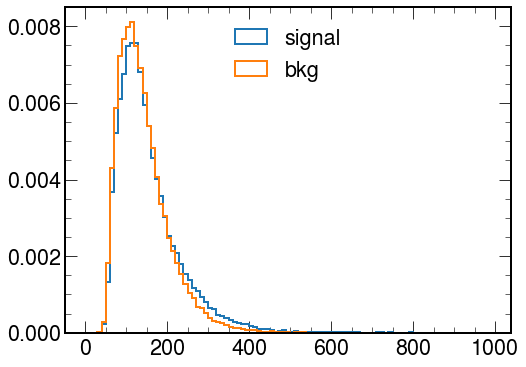

In [113]:
#plot last 5

plot('dijet_pt',100,0,1000)

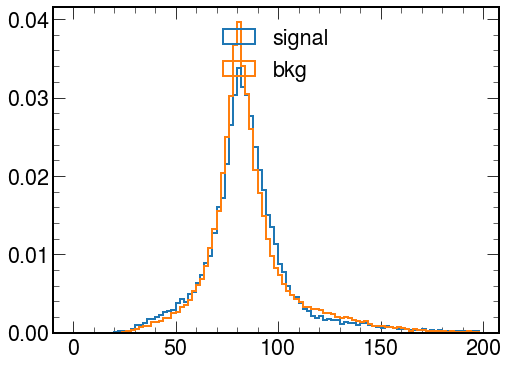

In [115]:
plot('dijet_mass',100,0,200)

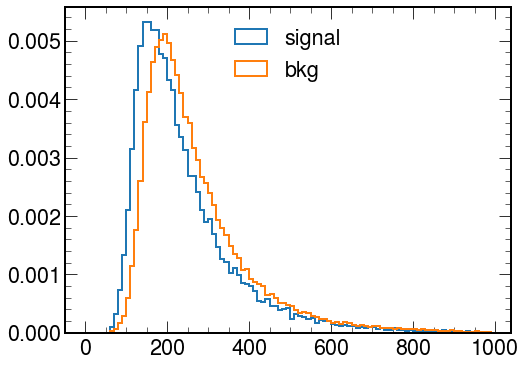

In [116]:
plot('event_HT',100,0,1000)

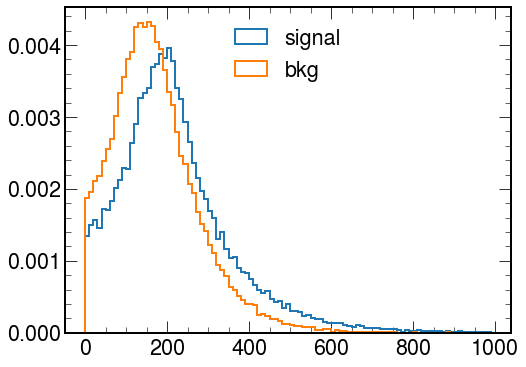

In [118]:
plot('dijet_mt',100,0,1000)

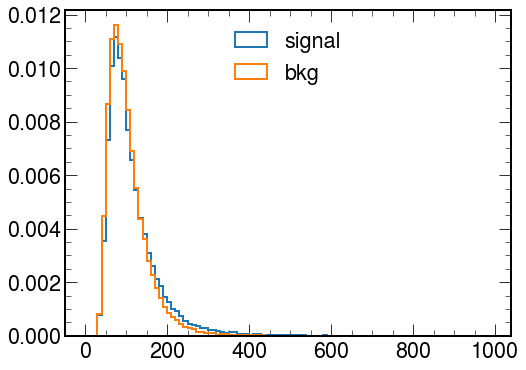

In [121]:
plot('jet0_pt',100,0,1000)

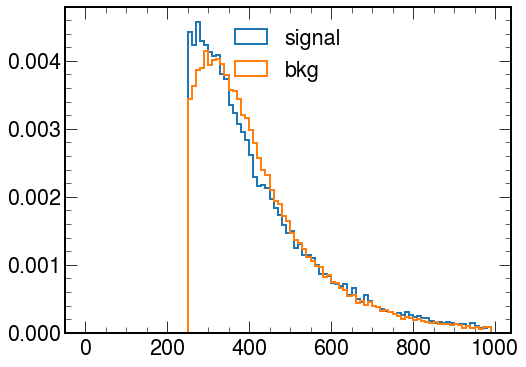

In [134]:
plot('event_ST',100,0,1000)

In [68]:
#import eli5

# Correlation Matrix

In [69]:
import seaborn as sns

In [136]:
sigdf.columns

Index(['lep0_pt', 'lep0_phi', 'lep0_eta', 'lep0_mt', 'jet0_pt', 'jet0_eta',
       'jet0_mt', 'jet1_pt', 'jet1_eta', 'jet1_mt', 'dijet_mass', 'dijet_pt',
       'dijet_mt', 'deltaR_jet01', 'deltaPhi_metjet0', 'deltaPhi_metjet1',
       'deltaPhi_metlep0', 'deltaPhi_jet0lep0', 'deltaPhi_jet1lep0',
       'deltaPhi_dijetlep0', 'deltaPhi_metdijet', 'event_MET', 'event_HT',
       'event_ST', 'n_Jet', 'ljjsys_PT', 'deltaPhi_ljjsysmet',
       'deltaPhi_ljjsyslep0', 'deltaPhi_ljjsysjet0', 'deltaPhi_ljjsysjet1',
       'ljjsys_mass', 'deepjetQG_jet0', 'deepjetQG_jet1', 'event_avgQGscore',
       'event_Rpt', 'label'],
      dtype='object')

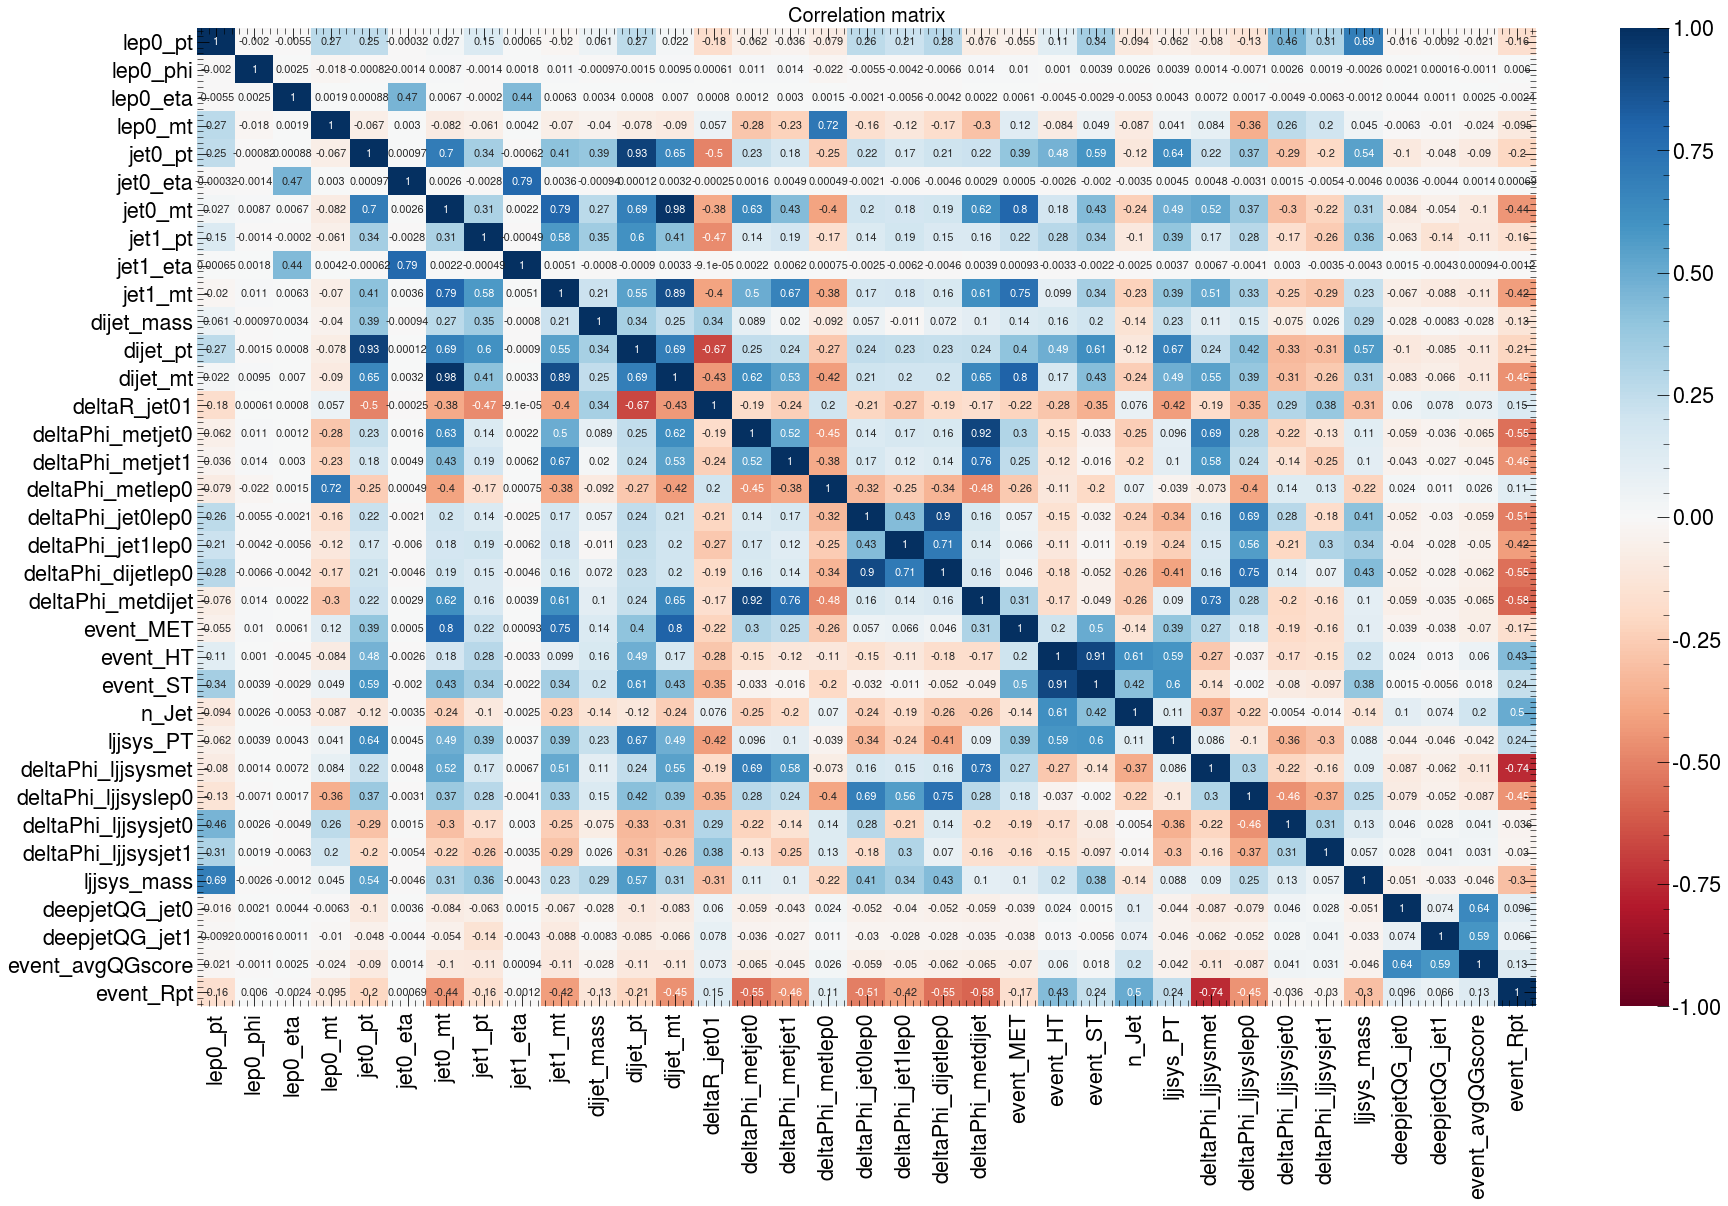

In [143]:
corrMatrix = data.drop('label',axis=1).corr()
plt.figure(figsize=(30,18))
sns.heatmap(corrMatrix, annot=True,annot_kws={'fontsize':11},cmap='RdBu',vmin=-1.0,vmax=1.0)
plt.title(f"Correlation matrix",fontsize=20)
#plt.savefig('CorrelationMatrix_ttjets_negCorr.png',facecolor='white',dpi=150,bbox_inches='tight')
plt.show()

### Correlation matrix for signal

In [140]:
#corrMatrix = sigdf.drop('label',axis=1).corr()
#plt.figure(figsize=(30,18))
#sns.heatmap(corrMatrix, annot=True,annot_kws={'fontsize':11},cmap='RdBu',vmin=-1.0,vmax=1.0)
#plt.title(f"Correlation matrix(signal)",fontsize=20)
#plt.savefig('CorrelationMatrix_ttjets_negCorr.png',facecolor='white',dpi=150,bbox_inches='tight')
#plt.show()

### correlation matrix for background

In [141]:

#corrMatrix = bkgdf.drop('label',axis=1).corr()
#plt.figure(figsize=(30,18))
#sns.heatmap(corrMatrix, annot=True,annot_kws={'fontsize':11},cmap='RdBu',vmin=-1.0,vmax=1.0)
#plt.title(f"Correlation matrix(ttjets)",fontsize=20)
#plt.savefig('CorrelationMatrix_ttjets_negCorr.png',facecolor='white',dpi=150,bbox_inches='tight')
#plt.show()

## Pairplot between most negatively correlated features

In [142]:
#sns.pairplot(data[['deltaR_jet01','dijet_pt','jet1_mt']])